# Extracting square sub-matrices from reference


### Conceptual considerations:

```
Summary statistics
↓
[window based clumping]
[ld based clumping]
↓
StudyLocus
↓
[ld matrix extraction] <- StudyIndex (studyId, ldPopulations), ldIndex, ldMatrix
↓

```


- Assume we have only one ancestry

In [1]:
from gentropy.common.session import Session
from gentropy.dataset.study_locus import StudyLocus
from gentropy.dataset.study_index import StudyIndex
from gentropy.datasource.gnomad.ld import GnomADLDMatrix
from gentropy.datasource.finngen.study_index import FinnGenStudyIndex

import hail as hl
from hail.linalg import BlockMatrix

from pyspark.sql import Window
import pyspark.sql.functions as f
from pyspark.sql import Column, DataFrame

from urllib.request import urlopen


session = Session(hail_home='/opt/conda/miniconda3/lib/python3.10/site-packages/hail', start_hail=True)



SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.
SLF4J: Class path contains SLF4J bindings targeting slf4j-api versions 1.7.x or earlier.
SLF4J: Ignoring binding found at [jar:file:/usr/lib/spark/jars/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See https://www.slf4j.org/codes.html#ignoredBindings for an explanation.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/backend/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/backend/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.3

## Generate FINNGEN Study table

- Executed in 2.22s
- Building a Finngen study table from source.

In [3]:
# Processing studies:
def update_population(ld_pop: Column) -> Column:
    return f.when(
            f.size(ld_pop) == 1,
            ld_pop.getItem(0).ldPopulation
        )


# Read the JSON data from the URL.
json_data = urlopen('https://r9.finngen.fi/api/phenos').read().decode("utf-8")
rdd = session.spark.sparkContext.parallelize([json_data])
df = session.spark.read.json(rdd)


finngen_release_prefix = 'FINNGEN_R9'
finngen_summary_stats_url_prefix = 'https://storage.googleapis.com/finngen-public-data-r9/summary_stats/finngen_R9_'
finngen_summary_stats_url_suffix = '.gz'

# Parse the study index data.
studies = FinnGenStudyIndex.from_source(
    df, 
    finngen_release_prefix, 
    finngen_summary_stats_url_prefix, 
    finngen_summary_stats_url_suffix
)

studies.df.show(1, False, True)

# From the study table we only need study identifier and the ld population
# We only need ld population if the study is based on single ancestry.
studies = (
    studies.df
    .select(
        'studyId',
        update_population(f.col('ldPopulationStructure')).alias('ldPopulation'), 
    )
    .distinct()
    .persist()
)

studies.show()

-RECORD 0--------------------------------------------------------------------------------------------------------------------
 studyId               | FINNGEN_R9_AB1_ACTINOMYCOSIS                                                                        
 traitFromSource       | Actinomycosis                                                                                       
 nCases                | 93                                                                                                  
 nControls             | 332343                                                                                              
 nSamples              | 332436                                                                                              
 projectId             | FINNGEN_R9                                                                                          
 studyType             | gwas                                                                                         

## Reading distance and ld clumped Finngen dataset

- Extract two random loci for prototyping purposes.
- Input dataset: 19,005 study locus from 1,387 studies.

In [6]:
sl = StudyLocus(
    _df= (
        session.spark.read
        .parquet('gs://genetics_etl_python_playground/XX.XX/output/python_etl/parquet/finngen/2023.10.13_ld_clumped_w_locus/')
        .filter(
            (f.size(f.col('qualityControls')) == 0) &
            (f.size(f.col('locus')) > 100)
        )
        .orderBy(f.rand(seed=23))
        .limit(2)
    ),
    _schema=StudyLocus.get_schema()
).persist()

# Get list of leads and studies:
sl.df.select('studyId', 'variantId', 'pValueMantissa', 'pValueExponent', ).show(truncate=False)

+-----------------------------------------+---------------+--------------+--------------+
|studyId                                  |variantId      |pValueMantissa|pValueExponent|
+-----------------------------------------+---------------+--------------+--------------+
|FINNGEN_R9_C3_BASAL_CELL_CARCINOMA_EXALLC|15_29035680_G_A|2.076         |-21           |
|FINNGEN_R9_G6_SLEEPAPNO                  |16_53771295_C_A|2.149         |-26           |
+-----------------------------------------+---------------+--------------+--------------+



In [148]:
# Let's get all top-loci from this study on chromosome 15:
(
    session.spark.read
    .parquet('gs://genetics_etl_python_playground/XX.XX/output/python_etl/parquet/finngen/2023.10.13_ld_clumped_w_locus/')
    .filter(
        (f.col('studyId') == 'FINNGEN_R9_C3_BASAL_CELL_CARCINOMA_EXALLC') &
        (f.col('chromosome') == '15') 
#         f.col('ldSet').isNotNull()
    )
    .orderBy(f.col('position'))
    .select(
        'studyLocusId',
        'variantId', 
        f.concat_ws('E','pValueMantissa', 'pValueExponent').alias('pValue'), 
#         'studyLocusId', 
        f.size(f.col('locus')).alias('locusSize'),
        f.size(f.col('ldSet')).alias('ldSetSize'),
        f.col('qualityControls')
    )
#     .count()
    .show(20, truncate=False)
)

+--------------------+---------------+---------+---------+---------+-----------------------------------+
|studyLocusId        |variantId      |pValue   |locusSize|ldSetSize|qualityControls                    |
+--------------------+---------------+---------+---------+---------+-----------------------------------+
|-6067699795164145074|15_27427129_A_G|9.592E-13|738      |35       |[]                                 |
|-8027743839728879857|15_27983407_C_T|4.618E-61|837      |78       |[]                                 |
|4889075444063922922 |15_28519016_G_A|2.786E-33|277      |-1       |[Variant not found in LD reference]|
|2224601896262245870 |15_29035680_G_A|2.076E-21|647      |5        |[]                                 |
|-7676564604508510836|15_48134287_A_G|3.572E-12|442      |34       |[]                                 |
+--------------------+---------------+---------+---------+---------+-----------------------------------+



## Comparing with Finngen finemapping.

The same [trait](https://r9.finngen.fi/pheno/C3_BASAL_CELL_CARCINOMA_EXALLC) has 3 finemapped credible sets.

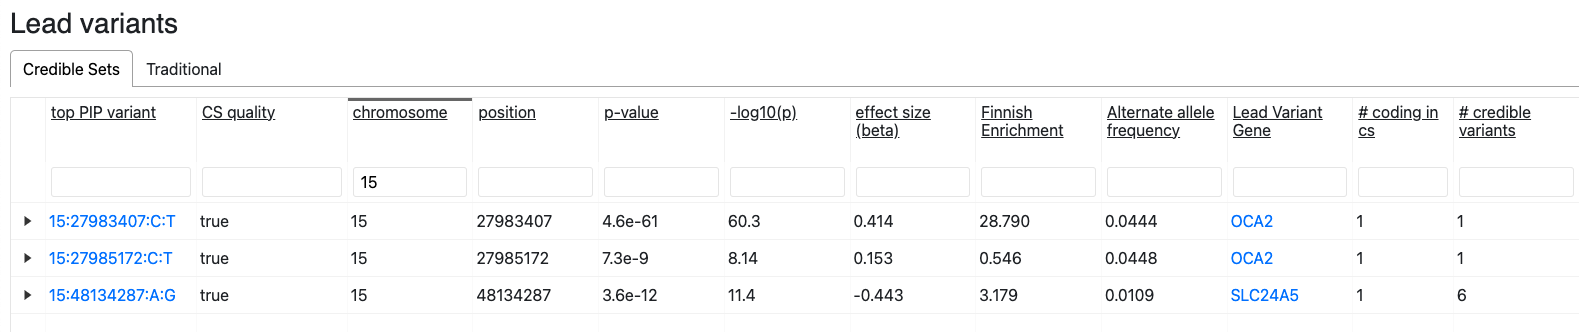

- `15:27983407:C:T` and `15:27985172:C:T` are very close, I could find `27983407`.
- Also `15_48134287_A_G` is found by both approach.
- One of the other three snps was not found in the LD set (`15_28519016_G_A`). 
- `15_27427129_A_G` and `15_29035680_G_A` were resolved in the LD matrix, and were found to be not linked. But they are not in the.

What are the r between these variants?

- 15_27983407_C_T vs 15_27427129_A_G -> r = 
- 15_27983407_C_T vs 15_29035680_G_A -> r =

In [144]:
# Extracting and resolving ld:
resolved_ld_index = (
    session.spark.read
    .parquet('gs://genetics_etl_python_playground/XX.XX/output/python_etl/parquet/finngen/2023.10.13_ld_clumped_w_locus/')
    .filter(
        (f.col('studyId') == 'FINNGEN_R9_C3_BASAL_CELL_CARCINOMA_EXALLC') &
        f.col('variantId').isin(['15_27983407_C_T', '15_27427129_A_G', '15_29035680_G_A'])
    )
    .orderBy(f.col('position'))
    .select(
        'variantId', 
        f.concat_ws('E','pValueMantissa', 'pValueExponent').alias('pValue'), 
#         'studyLocusId', 
        f.size(f.col('locus')).alias('locusSize'),
        f.size(f.col('ldSet')).alias('ldSetSize'),
        f.col('qualityControls')
    )
#     .count()
    .join(ld_index, on = 'variantId', how='left')
    .persist()
)

resolved_ld_index.show()

+---------------+---------+---------+---------+---------------+----------+--------+--------+------------+
|      variantId|   pValue|locusSize|ldSetSize|qualityControls|chromosome|position|     idx|ldPopulation|
+---------------+---------+---------+---------+---------------+----------+--------+--------+------------+
|15_27427129_A_G|9.592E-13|      738|       35|             []|        15|27427129|11130387|         fin|
|15_27983407_C_T|4.618E-61|      837|       78|             []|        15|27983407|11133253|         fin|
|15_29035680_G_A|2.076E-21|      647|        5|             []|        15|29035680|11136878|         fin|
+---------------+---------+---------+---------+---------------+----------+--------+--------+------------+



In [147]:
# Accessing r data from the LD matrix:
half_matrix = (
    BlockMatrix
    .read(ld_matrix_template.format(POP=ld_population))
    .filter(
        [row['idx'] for row in resolved_ld_index.select('idx').collect()],
        [row['idx'] for row in resolved_ld_index.select('idx').collect()]
    )
)

# matrix = half_matrix + half_matrix.T
matrix.entries().to_spark().show(100, truncate=False)

2023-10-27 10:23:48.619 Hail: INFO: Coerced sorted dataset                      


+---+---+------------------+
|i  |j  |entry             |
+---+---+------------------+
|0  |0  |2.0000000000000084|
|0  |1  |0.4201370447477838|
|0  |2  |0.0               |
|1  |0  |0.4201370447477838|
|1  |1  |2.0000000000000004|
|1  |2  |0.0               |
|2  |0  |0.0               |
|2  |1  |0.0               |
|2  |2  |1.9999999999999996|
+---+---+------------------+



In [153]:
study_locus_id = -8027743839728879857

# Running susie for a specific study locus:
sl = StudyLocus(
    _df= (
        session.spark.read
        .parquet('gs://genetics_etl_python_playground/XX.XX/output/python_etl/parquet/finngen/2023.10.13_ld_clumped_w_locus/')
        .filter(f.col('studyLocusId') == study_locus_id)
    ),
    _schema=StudyLocus.get_schema()
).persist()

sl.df.show()

+---------------+----------+--------------------+--------------------+--------+--------+---------+--------------------------------+--------------------------------+---------------------------+---------------------------+--------------+--------------+-------------------------------+-------------+-------------------+---------------+-----------------+--------------------+--------------------+
|      variantId|chromosome|             studyId|        studyLocusId|position|    beta|oddsRatio|oddsRatioConfidenceIntervalLower|oddsRatioConfidenceIntervalUpper|betaConfidenceIntervalLower|betaConfidenceIntervalUpper|pValueMantissa|pValueExponent|effectAlleleFrequencyFromSource|standardError|subStudyDescription|qualityControls|finemappingMethod|               locus|               ldSet|
+---------------+----------+--------------------+--------------------+--------+--------+---------+--------------------------------+--------------------------------+---------------------------+----------------------

## Annotating study locus with ld population + Get list of ancestires

In [154]:
# Adding ld population to study locus:
dl_df = (
    sl.df
    .join(studies, on='studyId', how='left')
    .persist()
)

dl_df.show(1, vertical=True)

# Extract the required ld populations:
ld_populations = [row['ldPopulation'] for row in dl_df.select('ldPopulation').distinct().collect()]

ld_populations

-RECORD 0------------------------------------------------
 studyId                          | FINNGEN_R9_C3_BAS... 
 variantId                        | 15_27983407_C_T      
 chromosome                       | 15                   
 studyLocusId                     | -8027743839728879857 
 position                         | 27983407             
 beta                             | 0.413866             
 oddsRatio                        | null                 
 oddsRatioConfidenceIntervalLower | null                 
 oddsRatioConfidenceIntervalUpper | null                 
 betaConfidenceIntervalLower      | 0.388762             
 betaConfidenceIntervalUpper      | 0.43897              
 pValueMantissa                   | 4.618                
 pValueExponent                   | -61                  
 effectAlleleFrequencyFromSource  | 0.0443583            
 standardError                    | 0.025104             
 subStudyDescription              | null                 
 qualityContro

['fin']

## Read ld index

In [155]:
from gentropy.common.utils import _liftover_loci, convert_gnomad_position_to_ensembl

def _process_ld_indices(
    ld_index_raw: hl.Table, 
    grch37_to_grch38_chain_path: str
) -> DataFrame:
    """Creates a look up table between variants and their coordinates in the LD Matrix.

    !!! info "Gnomad's LD Matrix and Index are based on GRCh37 coordinates. This function will lift over the coordinates to GRCh38 to build the lookup table."

    Args:
        ld_index_raw (hl.Table): LD index table from GnomAD
        grch37_to_grch38_chain_path (str): Path to the chain file used to lift over the coordinates

    Returns:
        DataFrame: Look up table between variants in build hg38 and their coordinates in the LD Matrix
    """
    ld_index_38 = _liftover_loci(
        ld_index_raw, grch37_to_grch38_chain_path, "GRCh38"
    )

    return (
        ld_index_38.to_spark()
        # Filter out variants where the liftover failed
        .filter(f.col("`locus_GRCh38.position`").isNotNull())
        .withColumn(
            "chromosome", f.regexp_replace("`locus_GRCh38.contig`", "chr", "")
        )
        # Temporary filter:
        .filter(f.col('chromosome').isin(['16', '15']))
        .withColumn(
            "position",
            convert_gnomad_position_to_ensembl(
                f.col("`locus_GRCh38.position`"),
                f.col("`alleles`").getItem(0),
                f.col("`alleles`").getItem(1),
            ),
        )
        .select(
            "chromosome",
            "position",
            f.concat_ws(
                "_",
                f.col("chromosome"),
                f.col("position"),
                f.col("`alleles`").getItem(0),
                f.col("`alleles`").getItem(1),
            ).alias("variantId"),
            f.col("idx"),
        )
        # Filter out ambiguous liftover results: multiple indices for the same variant
        .withColumn("count", f.count("*").over(Window.partitionBy(["variantId"])))
        .filter(f.col("count") == 1)
        .drop("count")
    )


- Full genome: 5min

In [156]:
grch37_to_grch38_chain_path = 'gs://hail-common/references/grch37_to_grch38.over.chain.gz'
ld_index_raw_template = 'gs://gcp-public-data--gnomad/release/2.1.1/ld/gnomad.genomes.r2.1.1.{POP}.common.ld.variant_indices.ht'
ld_matrix_template ='gs://gcp-public-data--gnomad/release/2.1.1/ld/gnomad.genomes.r2.1.1.{POP}.common.adj.ld.bm'


ld_population = 'fin'
ld_index_raw_path = ld_index_raw_template.format(POP=ld_population)

ld_index = (
    _process_ld_indices(
        hl.read_table(ld_index_raw_path),
        grch37_to_grch38_chain_path,
    )
    .withColumn('ldPopulation', f.lit(ld_population))
    .persist()
)

ld_index.show()

+----------+---------+--------------------+--------+------------+
|chromosome| position|           variantId|     idx|ldPopulation|
+----------+---------+--------------------+--------+------------+
|        15|100068435|    15_100068435_C_T|11488485|         fin|
|        15|100074914|    15_100074914_T_C|11488528|         fin|
|        15|100082112|    15_100082112_C_G|11488600|         fin|
|        15|100084933|    15_100084933_C_T|11488622|         fin|
|        15|100086055|    15_100086055_C_T|11488643|         fin|
|        15|100102338|15_100102338_CGAA...|11488802|         fin|
|        15|100102474|    15_100102474_A_G|11488806|         fin|
|        15|100140453|  15_100140453_G_GAC|11489087|         fin|
|        15|100141050|    15_100141050_G_A|11489092|         fin|
|        15|100149133|    15_100149133_G_T|11489141|         fin|
|        15|100270659|    15_100270659_G_A|11490053|         fin|
|        15|100317282|    15_100317282_T_C|11490464|         fin|
|        1

In [157]:
# how to do the join?
window_size = 250_000
tags = (
    # Pre-process study locus:
    f.broadcast(dl_df)
    .select('studyLocusId', 'chromosome', 'position', 'ldPopulation')
    .alias('study_locus')
    .join(
        (
            ld_index
            .selectExpr(*[f"{col} as ld_index_{col}" for col in ld_index.columns])
            .alias('ld_index')
        ),
        on = [
            (f.col('ld_index.ld_index_chromosome') == f.col('study_locus.chromosome')) & 
            (f.col('ld_index.ld_index_ldPopulation') == f.col('study_locus.ldPopulation')) &
            (f.col('ld_index.ld_index_position') >= f.col('study_locus.position') - window_size) & 
            (f.col('ld_index.ld_index_position') <= f.col('study_locus.position') + window_size)
        ],
        how='left'
    )
    .select(
        'studyLocusId',
        'chromosome',
        f.col('ld_index_variantId').alias('variantId'),
        f.col('ld_index_idx').alias('idx'),
        f.col('ld_index_position'),
        f.col('ld_index_ldPopulation').alias('ldPopulation')
    )
    .persist()
)

In [158]:
tags.groupby('studyLocusId').count().show()

+--------------------+-----+
|        studyLocusId|count|
+--------------------+-----+
|-8027743839728879857| 2079|
+--------------------+-----+



In [159]:
# Collecting region:
ld_windows = (
    tags
    .orderBy('studyLocusId', 'ld_index_position')
    .groupBy('studyLocusId', 'chromosome', 'ldPopulation')
    .agg(
        f.first(f.col('ld_index_position')).alias('first_position'),
        f.first(f.col('variantId')).alias('first_variantId'),
        f.first(f.col('idx')).alias('first_idx'),
        f.last(f.col('ld_index_position')).alias('last_position'),
        f.last(f.col('variantId')).alias('last_variantId'),
        f.last(f.col('idx')).alias('last_idx'),
        f.size(f.collect_list(f.col('variantId'))).alias('ldVariantCount')
    )
    .withColumn('window_length', f.col('last_position') - f.col('first_position'))
    .persist()
)

(
    ld_windows
    .select(
        'studyLocusId',
        'chromosome',
        'first_position',
        'last_position',
        'window_length',
        'first_idx',
        'last_idx',
        'ldVariantCount'
    )
    .show(truncate=False)
)


ld_windows.count()

+--------------------+----------+--------------+-------------+-------------+---------+--------+--------------+
|studyLocusId        |chromosome|first_position|last_position|window_length|first_idx|last_idx|ldVariantCount|
+--------------------+----------+--------------+-------------+-------------+---------+--------+--------------+
|-8027743839728879857|15        |27733460      |28232552     |499092       |11131979 |11134057|2079          |
+--------------------+----------+--------------+-------------+-------------+---------+--------+--------------+



1

In [160]:
row = ld_windows.collect()[0]
row

Row(studyLocusId=-8027743839728879857, chromosome='15', ldPopulation='fin', first_position=27733460, first_variantId='15_27733460_AGCCAAACTGGCTCATGGCC_A', first_idx=11131979, last_position=28232552, last_variantId='15_28232552_G_GA', last_idx=11134057, ldVariantCount=2079, window_length=499092)

In [161]:
ld_population = row['ldPopulation']
study_locus_id = row['studyLocusId']
chromosome = row['chromosome']
first_index = row['first_idx']
last_index = row['last_idx']

# For each row, we need to open the gnomad 
half_matrix = (
    BlockMatrix
    .read(ld_matrix_template.format(POP=ld_population))
    .filter(
        range(first_index, last_index),
        range(first_index, last_index)
    )
)

matrix = half_matrix + half_matrix.T


In [162]:
(
    matrix.entries().to_spark()
    .select(
        (f.col('i')+first_index).alias('idx_i'),
        (f.col('j')+first_index).alias('idx_j'),
        f.when(f.col('i') == f.col('j'), f.col('entry')/2).otherwise(f.col('entry')).alias('r'),
        f.lit(study_locus_id).alias('study_locus_ids')
    )
    # Joining with i:
    .join(
        (
            tags
            .select(
                f.col('variantId').alias('variantIdLeft'), 
                f.col('idx').alias('idx_i')
            )
        ), 
        on='idx_i', how='outer'
    )
    # Joining with i:
    .join(
        (
            tags
            .select(
                'chromosome', 
                f.col('variantId').alias('variantIdRight'), 
                f.col('idx').alias('idx_j')
            )
        ), 
        on='idx_j', how='outer'
    )
    .select(
        'variantIdLeft',
        'variantIdRight',
        'study_locus_ids',
        'r'
    )
    .distinct()
    .write.mode('overwrite').parquet(f'gs://ot-team/dsuveges/ld_matrix-{study_locus_id}')
)

2023-10-27 11:26:58.169 Hail: INFO: Coerced sorted dataset                      


In [164]:
study_locus_id = -8027743839728879857

# Get data:
ld_matrix = session.spark.read.parquet(f'gs://ot-team/dsuveges/ld_matrix-{study_locus_id}')

# Select one study locus:
selected_locus = (
    dl_df
    .filter(f.col('studyLocusId') == study_locus_id)
    .select(
        '*',
        f.explode_outer('locus').alias('exploded_locus')
    )
    .select(
        'studyId',
        f.col('variantId').alias('variantIdLead'),
        f.col('studyLocusId'),
        *[f'exploded_locus.{col}' for col in ['variantId', 'pValueMantissa', 'pValueExponent', 'beta', 'standardError']]
    )
    .persist()
)

selected_locus.show(1, False, True)
selected_locus.count()

-RECORD 0---------------------------------------------------
 studyId        | FINNGEN_R9_C3_BASAL_CELL_CARCINOMA_EXALLC 
 variantIdLead  | 15_27983407_C_T                           
 studyLocusId   | -8027743839728879857                      
 variantId      | 15_27733459_AGCCAAACTGGCTCATGGCC_A        
 pValueMantissa | 1.937                                     
 pValueExponent | -2                                        
 beta           | 0.0267247                                 
 standardError  | 0.011429                                  
only showing top 1 row



837

In [189]:
# Filtering matrix:
processed_matrix = (
    ld_matrix
    .join(
        selected_locus.select(f.col('variantId').alias('variantIdLeft')),
        on='variantIdLeft', how='inner'
    )
    .join(
        selected_locus.withColumnRenamed('variantId', 'variantIdRight'), 
        on='variantIdRight', how='inner'
    )
    .select(
        'studyId',
        'studyLocusId',
        'variantIdLead',
        'variantIdLeft',
        'variantIdRight',
        f.col('pValueMantissa').alias('pValueMantissaRight'),
        f.col('pValueExponent').alias('pValueExponentRight'),
        f.col('beta').alias('betaRight'),
        f.col('standardError').alias('standardErrorRight'),
        'r'
    )
    .persist()
)

processed_matrix.show()
print(processed_matrix.count())
print(sqrt(processed_matrix.count()))
processed_matrix.select('variantIdRight').distinct().count()

+--------------------+--------------------+---------------+---------------+---------------+-------------------+-------------------+----------+------------------+--------------------+
|             studyId|        studyLocusId|  variantIdLead|  variantIdLeft| variantIdRight|pValueMantissaRight|pValueExponentRight| betaRight|standardErrorRight|                   r|
+--------------------+--------------------+---------------+---------------+---------------+-------------------+-------------------+----------+------------------+--------------------+
|FINNGEN_R9_C3_BAS...|-8027743839728879857|15_27983407_C_T|15_27792793_C_T|15_27772290_T_C|              9.979|                 -6| 0.0730063|         0.0165261|  0.3188276023578284|
|FINNGEN_R9_C3_BAS...|-8027743839728879857|15_27983407_C_T|15_27950388_C_T|15_27778556_C_T|              1.142|                 -2|  0.119731|         0.0473309| -0.1845689041174883|
|FINNGEN_R9_C3_BAS...|-8027743839728879857|15_27983407_C_T|15_28104601_A_T|15_2780920

621

In [167]:

pivoted_matrix = (
    processed_matrix
    .orderBy(f.col('variantIdLeft'), f.col('variantIdRight'))
    .groupBy('variantIdLeft')
    .pivot("variantIdRight")
    .agg(f.first('r'))
    .orderBy('variantIdLeft')
    # Convert to numpy array ingested by SuSie:
    .toPandas().set_index('variantIdLeft').to_numpy()
)

pivoted_matrix[0:5, 0:5]

array([[1.        , 0.88019644, 0.28333008, 0.25666969, 0.26345801],
       [0.88019644, 1.        , 0.26027515, 0.24115952, 0.2442993 ],
       [0.28333008, 0.26027515, 1.        , 0.85898573, 0.89168227],
       [0.25666969, 0.24115952, 0.85898573, 1.        , 0.96268566],
       [0.26345801, 0.2442993 , 0.89168227, 0.96268566, 1.        ]])

In [90]:
pivoted_matrix.toPandas().set_index('variantIdLeft').to_numpy()

array([[ 1.        ,  0.99851182,  0.85089485, ...,  0.04532387,
         0.02258468,  0.02476075],
       [ 0.99851182,  1.        ,  0.85111292, ...,  0.0465783 ,
         0.02253374,  0.02470884],
       [ 0.85089485,  0.85111292,  1.        , ...,  0.04748182,
         0.01191697,  0.01652519],
       ...,
       [ 0.04532387,  0.0465783 ,  0.04748182, ...,  1.        ,
        -0.05908013, -0.05417476],
       [ 0.02258468,  0.02253374,  0.01191697, ..., -0.05908013,
         1.        ,  0.96019982],
       [ 0.02476075,  0.02470884,  0.01652519, ..., -0.05417476,
         0.96019982,  1.        ]])

In [190]:
(
    processed_matrix
    # Convert to numpy array ingested by SuSie:
    .write.mode('overwrite').parquet(f'gs://ot-team/dsuveges/processed-ld-matrix-{study_locus_id}')
)

In [169]:
# selected_locus.write.mode('overwrite').parquet('gs://ot-team/dsuveges/selected_studyLocus_2224601896262245870')
(
    processed_matrix
    .select(
        'studyId',
        f.col('variantIdRight').alias('variantId'),
        f.col('pValueMantissaRight').alias('pValueMantissa'),
        f.col('pValueExponentRight').alias('pValueExponent'),
        f.col('betaRight').alias('beta'),
        f.col('standardErrorRight').alias('standardError'),
    )
    .distinct()
    .write.mode('overwrite').parquet(f'gs://ot-team/dsuveges/selected_studyLocus_{study_locus_id}')
)

In [187]:
print(
    '\n'.join(
        [
            ',  '.join([f'{value**2:.2f}' for value in row]) 
            for row in
            (
                pivoted_matrix
                [[291, 293, 295, 322, 323, 508, 514, 529, 534, 515]]
                [:,[291, 293, 295, 322, 323, 508, 514, 529, 534, 515]]
            )
        ]
    )
)

1.00,  0.18,  0.18,  0.97,  0.97,  0.15,  0.18,  0.11,  0.13,  0.12
0.18,  1.00,  0.99,  0.15,  0.15,  0.03,  0.03,  0.02,  0.01,  0.02
0.18,  0.99,  1.00,  0.15,  0.15,  0.03,  0.03,  0.02,  0.01,  0.02
0.97,  0.15,  0.15,  1.00,  1.00,  0.14,  0.17,  0.11,  0.12,  0.12
0.97,  0.15,  0.15,  1.00,  1.00,  0.14,  0.17,  0.11,  0.12,  0.12
0.15,  0.03,  0.03,  0.14,  0.14,  1.00,  0.32,  0.45,  0.50,  0.25
0.18,  0.03,  0.03,  0.17,  0.17,  0.32,  1.00,  0.29,  0.33,  0.52
0.11,  0.02,  0.02,  0.11,  0.11,  0.45,  0.29,  1.00,  0.91,  0.29
0.13,  0.01,  0.01,  0.12,  0.12,  0.50,  0.33,  0.91,  1.00,  0.33
0.12,  0.02,  0.02,  0.12,  0.12,  0.25,  0.52,  0.29,  0.33,  1.00


In [188]:
processed_matrix.show()

+--------------------+--------------------+---------------+---------------+---------------+-------------------+-------------------+----------+------------------+--------------------+
|             studyId|        studyLocusId|  variantIdLead|  variantIdLeft| variantIdRight|pValueMantissaRight|pValueExponentRight| betaRight|standardErrorRight|                   r|
+--------------------+--------------------+---------------+---------------+---------------+-------------------+-------------------+----------+------------------+--------------------+
|FINNGEN_R9_C3_BAS...|-8027743839728879857|15_27983407_C_T|15_27792793_C_T|15_27772290_T_C|              9.979|                 -6| 0.0730063|         0.0165261|  0.3188276023578284|
|FINNGEN_R9_C3_BAS...|-8027743839728879857|15_27983407_C_T|15_27950388_C_T|15_27778556_C_T|              1.142|                 -2|  0.119731|         0.0473309| -0.1845689041174883|
|FINNGEN_R9_C3_BAS...|-8027743839728879857|15_27983407_C_T|15_28104601_A_T|15_2780920